In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Softmax,Flatten,MaxPooling2D,Dropout,Activation, Lambda, concatenate,BatchNormalization
from keras.datasets import cifar100, cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import kullback_leibler_divergence
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy
from keras import regularizers
from keras import optimizers
from keras import backend as K
import torch
import gc
#import seaborn as sns
import h5py
import sys

#import os
import pandas as pd
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Add, BatchNormalization, Activation
from keras.activations import relu, softmax
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
tf.config.run_functions_eagerly(True)

In [2]:
# Cifar100

num_classes_fine = 100
num_classes_coarse= 20
(x_train_100, y_train_f), (x_test_100, y_test_f) = cifar100.load_data()
(x_train_100, y_train_coarse), (x_test_100, y_test_coarse) = cifar100.load_data(label_mode='coarse')

#x_train_100= x_train_100[:30000]
#y_train_f= y_train_f[:30000]



x_train_100 = x_train_100.astype('float32')
x_test_100 = x_test_100.astype('float32')

y_train_fine = to_categorical(y_train_f, num_classes_fine)
y_test_fine = to_categorical(y_test_f, num_classes_fine)
y_train_coarse = to_categorical(y_train_coarse, num_classes_coarse)
y_test_coarse = to_categorical(y_test_coarse, num_classes_coarse)


def normalize(X_train,X_test):
    mean = np.mean(X_train,axis=(0,1,2,3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    return X_train, X_test


x_train_100, x_test_100 = normalize(x_train_100, x_test_100)

print(f'x_train_100: {x_train_100.shape}     y_train_fine: {y_train_fine.shape}     y_train_coarse: {y_train_coarse.shape}')
print(f'x_test_100: {x_test_100.shape}       y_test_fine: {y_test_fine.shape}       y_test_coarse: {y_test_coarse.shape}')

x_train_100: (50000, 32, 32, 3)     y_train_fine: (50000, 100)     y_train_coarse: (50000, 20)
x_test_100: (10000, 32, 32, 3)       y_test_fine: (10000, 100)       y_test_coarse: (10000, 20)


In [3]:
def teacher_skip_connection_model(num_classes):

    global Temperature, sgd, y_true, y_pred

    input_residual= Input(shape=(32,32,3))
    residual= Conv2D(128,(4,4), strides=(4,4), padding='valid', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(input_residual)
    
    input= Input(shape=(8,8,128))
    teacher= Add()([residual, input])

    teacher= Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(teacher)
    teacher=BatchNormalization()(teacher)
    teacher=Dropout(0.4)(teacher)

    teacher= Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(teacher)
    teacher=BatchNormalization()(teacher)
    teacher=Dropout(0.4)(teacher)

    teacher=Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(teacher)
    teacher=BatchNormalization()(teacher)

    teacher=MaxPooling2D(pool_size=(2,2))(teacher)

    teacher=Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(teacher)
    teacher=BatchNormalization()(teacher)
    teacher=Dropout(0.4)(teacher)

    teacher=Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(teacher)
    teacher=BatchNormalization()(teacher)
    teacher=Dropout(0.4)(teacher)

    teacher=Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(teacher)
    teacher=BatchNormalization()(teacher)


    teacher=MaxPooling2D(pool_size=(2,2))(teacher)

    teacher= Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(teacher)
    teacher= BatchNormalization()(teacher)
    teacher= Dropout(0.4)(teacher)

    teacher= Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(teacher)
    teacher= BatchNormalization()(teacher)
    teacher= Dropout(0.4)(teacher)

    teacher= Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005))(teacher)
    teacher= BatchNormalization()(teacher)

    teacher= MaxPooling2D(pool_size=(2,2))(teacher)
    teacher= Dropout(0.5)(teacher)
 
    teacher= Flatten()(teacher)
    teacher= Dense(512, kernel_regularizer=regularizers.l2(0.0005))(teacher)
    teacher= Activation('relu')(teacher)
    teacher= BatchNormalization()(teacher)
    teacher= Dropout(0.5)(teacher)

    teacher= Dense(num_classes)(teacher)
    #teacher= Activation('softmax')(teacher)
    
    teacher= Model([input,input_residual], teacher)

    logits= teacher.layers[37].output
    probs= Activation('softmax')(logits)
    logits_T= Lambda(lambda x:x/Temperature)(logits)
    probs_T= Activation('softmax')(logits_T)

    CombinedLayers= concatenate([probs, probs_T])
    teacher= Model(teacher.input, CombinedLayers)

    teacher.compile(optimizer=sgd, loss=lambda y_true,y_pred: teacher_loss(y_true, y_pred), metrics=['accuracy'])


    return teacher

In [4]:

def student_model(num_classes):
    
    global sgd, y_true, y_pred, Temperature, Alpha
    student= Sequential()

    student.add(Conv2D(64,(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0005), input_shape=(32,32,3)))
    student.add(BatchNormalization())
    student.add(Dropout(0.3))

    student.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    student.add(BatchNormalization()) 

    student.add(MaxPooling2D(pool_size=(2,2)))

    student.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    student.add(BatchNormalization())
    student.add(Dropout(0.4))

    student.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    student.add(BatchNormalization())

    student.add(MaxPooling2D(pool_size=(2,2)))

    #student.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005), input_shape= (8,8,128)))
    #student.add(BatchNormalization())
    #student.add(Dropout(0.4))

    #student.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    #student.add(BatchNormalization())
    #student.add(Dropout(0.4))

    #student.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
    #student.add(BatchNormalization()) 

    #student.add(MaxPooling2D(pool_size=(2,2)))

    student.add(Flatten())
    student.add(Dense(512, kernel_regularizer=regularizers.l2(0.0005)))
    student.add(Activation('relu'))
    student.add(BatchNormalization())
    student.add(Dropout(0.5))

    student.add(Dense(num_classes))
    #student.add(Activation('softmax'))
 
    student_logits= student.layers[17].output  
    probs= Activation('softmax')(student_logits)                     # hard prediction
    logits_T= Lambda(lambda x:x/Temperature)(student_logits)         #z/T
    probs_T= Activation('softmax')(logits_T)                         # soft prediction

    CombinedLayers= concatenate([probs, probs_T])
    student= Model(student.input, CombinedLayers)
    student.compile(optimizer=sgd, loss=lambda y_true,y_pred: student_loss(y_true, y_pred, alpha=Alpha, T=Temperature), metrics=['accuracy'])

    return student

In [5]:
def teacher_loss(y_true, y_pred):
    global count, num_classes_t, pred_sum, pred_avg, batchsize
    y_true, y_true_soft= y_true[:,:num_classes_t], y_true[:, num_classes_t:]
    y_pred, y_pred_soft= y_pred[:,:num_classes_t], y_pred[:, num_classes_t:]

    #(y_pred,y_pred_soft) = tf.split(y_pred,num_or_size_splits = 2, axis = 1)
    #(y_true,y_true_soft) = tf.split(y_true,num_or_size_splits = 2, axis = 1)

    loss= keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.AUTO, from_logits=False)(y_true,y_pred)

    y_pred_soft_np=K.eval(y_pred_soft)
    y_true_np= K.eval(y_true)
 
    for i in range(y_pred_soft_np.shape[0]):  #(128,100)
        label= np.argmax(y_true_np[i])    
        pred_sum[label]= pred_sum[label] + y_pred_soft_np[i]
        count[label]= count[label]+1
        #print('\\ni: ', i)
        #print('label: ',label)
        #print('true_soft argmax: ', np.argmax(y_true_soft_np[i]))   
        #print('hard prediction for the batch: ', np.argmax(y_pred_np[i]))  
        #print('pred_sum[label] argmax: ', np.argmax(pred_sum[label]))
        #print('pred argmax > pred label?: ', np.argmax(y_pred_soft_np[i])>y_pred_soft_np[i,label])
 
 
    return loss

In [9]:
def student_loss(y_true, y_pred, alpha, T):
    global num_classes_s
    y_true, y_true_soft= y_true[:,:num_classes_s], y_true[:, num_classes_s:]
    y_pred, y_pred_soft= y_pred[:,:num_classes_s], y_pred[:, num_classes_s:]
    
    #cross-entropy loss (temperatureX)
    #CE_loss = categorical_crossentropy(y_true,y_pred)
    CE_loss= keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.AUTO, from_logits=False)(y_true,y_pred)
    
    #KL-divergence loss (temperatureO)
    KL_loss = (T**2)*(kullback_leibler_divergence(y_true_soft, y_pred_soft))
    
    loss= alpha*CE_loss + (1-alpha)*KL_loss
    print(loss)
    
    return loss

In [10]:
def distillation(student_epoch, teacher_epoch, iteration, batch_size, alpha, temperature):
    global count, Temperature, Alpha, pred_sum, pred_avg, sgd, num_classes_s, num_classes_t, batchsize
    
    s_d_val_loss = np.empty(student_epoch*iteration)
    s_d_val_acc = np.empty(student_epoch*iteration)
    t_d_val_loss = np.empty(teacher_epoch*iteration)
    t_d_val_acc = np.empty(teacher_epoch*iteration)
       
    #params
    Temperature= temperature
    #Alpha= alpha
    num_classes_s = num_classes_fine
    num_classes_t= num_classes_fine
    lr= 0.1
    lr_decay= 1e-6
    batchsize=batch_size
    weight_decay= 0.0005
    lr_drop=20
    pred_avg=np.zeros(num_classes_t) 
    
        
    #models
    sgd= optimizers.SGD(learning_rate= lr, decay= lr_decay, momentum=0.9, nesterov=True)
    teacher= teacher_skip_connection_model(num_classes_t)
    student= student_model(num_classes_s)
      
    
    for i in range(iteration):
     
        #student training
        print(f'student {i+1}th training')
        if i<2:   #한번은 update 되고 distill 받게(2)
            Alpha=1
        else:
            Alpha= alpha
              
        def lr_scheduler(student_epoch):
            return lr * (0.5 ** (student_epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

        y_train_soft= np.zeros((50000,num_classes_t))
        for index in range(50000):
            label= np.argmax(y_train_fine[index])
            y_train_soft[index]= pred_avg[label]
        y_train_new= np.c_[y_train_fine, y_train_soft]
           
        history_s= student.fit(x_train_100, y_train_new, batch_size=batchsize,
                               epochs= student_epoch, callbacks=[reduce_lr],
                               validation_split=0.2, shuffle=False, verbose=2)
         
        for e in range(student_epoch):
            s_d_val_loss[i*student_epoch +e]= history_s.history['val_loss'][e]
            s_d_val_acc[i*student_epoch +e]= history_s.history['val_accuracy'][e]
          



        #teacher training
        count=np.zeros(num_classes_t, dtype=np.int)
        pred_sum=np.zeros((num_classes_t, num_classes_t))
        pred_avg=np.zeros((num_classes_t, num_classes_t))  #initialize
     
        def lr_scheduler(teacher_epoch):
            return lr * (0.5 ** (teacher_epoch // lr_drop))
        reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)
            
        out_s= Model(inputs= student.input, outputs= student.layers[12].output)
        s_output= out_s.predict(x_train_100, batch_size=2)
        y_train_new= np.c_[y_train_fine, y_train_fine]
            
        print(f'teacher {i+1}th training')
        history_t= teacher.fit([s_output, x_train_100], y_train_new, batch_size= batchsize,
                               epochs= teacher_epoch, callbacks=[reduce_lr],
                               validation_split=0.2, shuffle=False, verbose=2)
        
            
        #바로 직전 iter의 pred만 student한테 줄때 이 loop안에서 초기화
        for classes in range(num_classes_t):
             pred_avg[classes]= pred_sum[classes]/count[classes]
        '''
        #학습 된 후 output뽑아서 label별 평균
        output= history_t.predict(s_output, batch_size=2)
        for classes in range(num_classes_t):
            label= np.argmax(y_train_fine[classes])
            pred_sum[label]= pred_sum[label]+ output[classes]
            count[classes]= count[classes]+1
        pred_avg[classes]=
        #loss바꿔야돼
        '''
            
        #모든걸 누적. count 로 나누면 안됌 이전에 count 랑 다시 곱한다음에 pred_sum 또 추출해서 더하든지
        
        for e in range(teacher_epoch):
            t_d_val_loss[i*teacher_epoch +e]= history_t.history['val_loss'][e]
            t_d_val_acc[i*teacher_epoch +e]= history_t.history['val_accuracy'][e]
                
    return student, teacher, s_d_val_loss, s_d_val_acc, t_d_val_loss, t_d_val_acc

In [11]:
student_epoch=5
teacher_epoch=20
iteration=10
batchsize=128 
Alpha=0.6
Temperature=4
student, teacher, s_d_val_loss, s_d_val_acc, t_d_val_loss, t_d_val_acc=distillation(student_epoch, teacher_epoch, iteration, batchsize, Alpha, Temperature)

student 1th training
Epoch 1/5
tf.Tensor(
[6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005
 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005
 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005
 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005
 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005
 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005
 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005
 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005
 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005
 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005
 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005
 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005
 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005 6.1752005
 6.1752005 6.1752005 6.1752005 6.17

KeyboardInterrupt: 

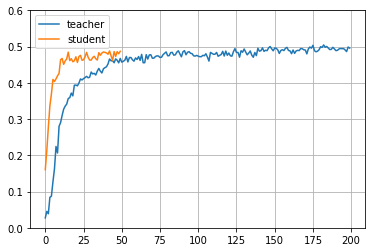

In [10]:
x_len= np.arange(200)
empty= np.zeros(150)
empty[:]=np.NaN
s_d_val_acc_2= np.hstack([s_d_val_acc,empty])

np.save('meta_skipconn_student.npy', s_d_val_acc_2)
np.save('meta_skipconn_teacher.npy', t_d_val_acc)
plt.plot(x_len, meta_student, '-', color='red', label='meta distill_student')
plt.plot(x_len, meta_teacher, '-', color='blue', label='meta distill_teacher')

plt.plot(x_len, t_d_val_acc, '-', label='teacher')
plt.plot(x_len, s_d_val_acc_2, '-', label='student')
plt.ylim(0,0.6)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# training 되고 output에서 뽑아서 해보자